In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [11]:
import arviz as az
import astropy.cosmology as cosmo
from astropy.cosmology import Planck15
import bz2
import astropy.units as u
import h5py
import pickle
import pystan
from sklearn.mixture import GaussianMixture
from scipy.interpolate import interp1d
import seaborn as sns
from true_params import true_params

sns.set_context('notebook')
sns.set_style('ticks')
sns.set_palette('colorblind')

In [3]:
samples = {}
with h5py.File('observations.h5', 'r') as f:
    for k in ['m1det', 'm2det', 'dl', 'log_m1m2dl_prior']:
        samples[k] = array(f['posteriors'][k])

In [4]:
sel = {}
with h5py.File('selected.h5', 'r') as f:
    sel['m1det'] = array(f['m1det'])
    sel['m2det'] = array(f['m2det'])
    sel['dldet'] = array(f['dl'])
    sel['wtdet'] = array(f['wt'])
    sel['N_gen'] = f.attrs['N_gen']

Earlier tests showed that the score pretty much stabilizes at 4 GMM components, so that's what I'm going to use.

In [6]:
nobs = 64
ncomp = 4

wts = []
mus = []
covs = []

for i in range(nobs):
    gmm = GaussianMixture(ncomp)
    w = exp(-(samples['log_m1m2dl_prior'][i,:]-np.min(samples['log_m1m2dl_prior'][i,:])))
    r = random.uniform(size=len(w))
    s = r < w
    print('Found {:d} samples'.format(count_nonzero(s)))
    pts = column_stack((samples['m1det'][i,s], samples['m2det'][i,s], samples['dl'][i,s]))
    gmm.fit(pts)
    
    wts.append(gmm.weights_)
    mus.append(gmm.means_)
    covs.append(gmm.covariances_)

Found 1338 samples
Found 813 samples
Found 2285 samples
Found 2504 samples
Found 2079 samples
Found 1385 samples
Found 1992 samples
Found 1858 samples
Found 2167 samples
Found 1158 samples
Found 1192 samples
Found 1887 samples
Found 203 samples
Found 2243 samples
Found 1075 samples
Found 2348 samples
Found 661 samples
Found 1824 samples
Found 1736 samples
Found 1265 samples
Found 1800 samples
Found 2245 samples
Found 2416 samples
Found 1330 samples
Found 1260 samples
Found 1121 samples
Found 1687 samples
Found 1054 samples
Found 1986 samples
Found 1444 samples
Found 2419 samples
Found 1220 samples
Found 1694 samples
Found 1803 samples
Found 1599 samples
Found 852 samples
Found 1835 samples
Found 2310 samples
Found 625 samples
Found 1485 samples
Found 1377 samples
Found 1195 samples
Found 995 samples
Found 1526 samples
Found 2045 samples
Found 1565 samples
Found 2157 samples
Found 670 samples
Found 831 samples
Found 651 samples
Found 1018 samples
Found 2130 samples
Found 977 samples
Fou

In [7]:
nsel = 1024

ninterp = 500
zmax = 10
zinterp = expm1(linspace(log(1), log(zmax+1), ninterp))

# This is the UL on the true dL we will permit; shouldn't even need to go up this high, but just to be safe
dlmax = Planck15.luminosity_distance(3).to(u.Gpc).value

mnorm = exp(arange(log(1), log(200), 0.01))
nnorm = len(mnorm)

data = {
    'nobs': nobs,
    'nsel': nsel,
    'ninterp': ninterp,
    'nnorm': nnorm,
    'ncomp': ncomp,
    
    'Tobs': 0.5/12.0,
    'N_gen': int(round(nsel/float(len(sel['m1det']))*sel['N_gen'])),
    
    'mu': mus,
    'cov': covs,
    'wts': wts,
    
    'm1sel': sel['m1det'][:nsel],
    'm2sel': sel['m2det'][:nsel],
    'dlsel': sel['dldet'][:nsel],
    'wtsel': sel['wtdet'][:nsel],
    
    'zinterp': zinterp,
    
    'ms_norm': mnorm,
    'dl_max': Planck15.luminosity_distance(zmax).to(u.Gpc).value,
    
    'use_cosmo_prior': 0,
    'mu_H0': 70.0,
    'sigma_H0': 1.0,
    'mu_Omh2': 0.3*0.7*0.7,
    'sigma_Omh2': 0.01*0.3*0.7*0.7
}

In [8]:
model = pystan.StanModel(file='model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_37e0c037fa76d60383d498e05a0d5faf NOW.


In [9]:
fit = model.sampling(data=data, iter=200)

In [10]:
print(fit)

Inference for Stan model: anon_model_37e0c037fa76d60383d498e05a0d5faf.
4 chains, each with iter=200; warmup=100; thin=1; 
post-warmup draws per chain=100, total post-warmup draws=400.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
H0           62.56    0.64  12.92  39.73  52.88  62.05   70.5  90.25    409    1.0
Om            0.28  4.9e-3   0.15   0.03   0.16   0.27   0.37   0.61    883   0.99
w            -1.09    0.02   0.39  -1.76   -1.4   -1.1  -0.83  -0.35    467    1.0
R0          136.08    2.61  51.01  67.87  98.46 123.88 163.72 266.97    383    1.0
MMin          4.85    0.06    1.1   3.08   4.16   4.75   5.36   7.44    317    1.0
MMax         45.42    0.28   4.69   35.7  42.42   45.5  48.24  54.85    274    1.0
alpha         1.02    0.02   0.39   0.16   0.79   1.03   1.29   1.76    326    1.0
beta          0.08    0.02   0.47  -0.86  -0.23   0.07   0.42   1.02    429    1.0
gamma          2.5    0.04   0.81   0.81    1.9   2.48   3.08   4.07

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c660f25f8>,
      dtype=object)

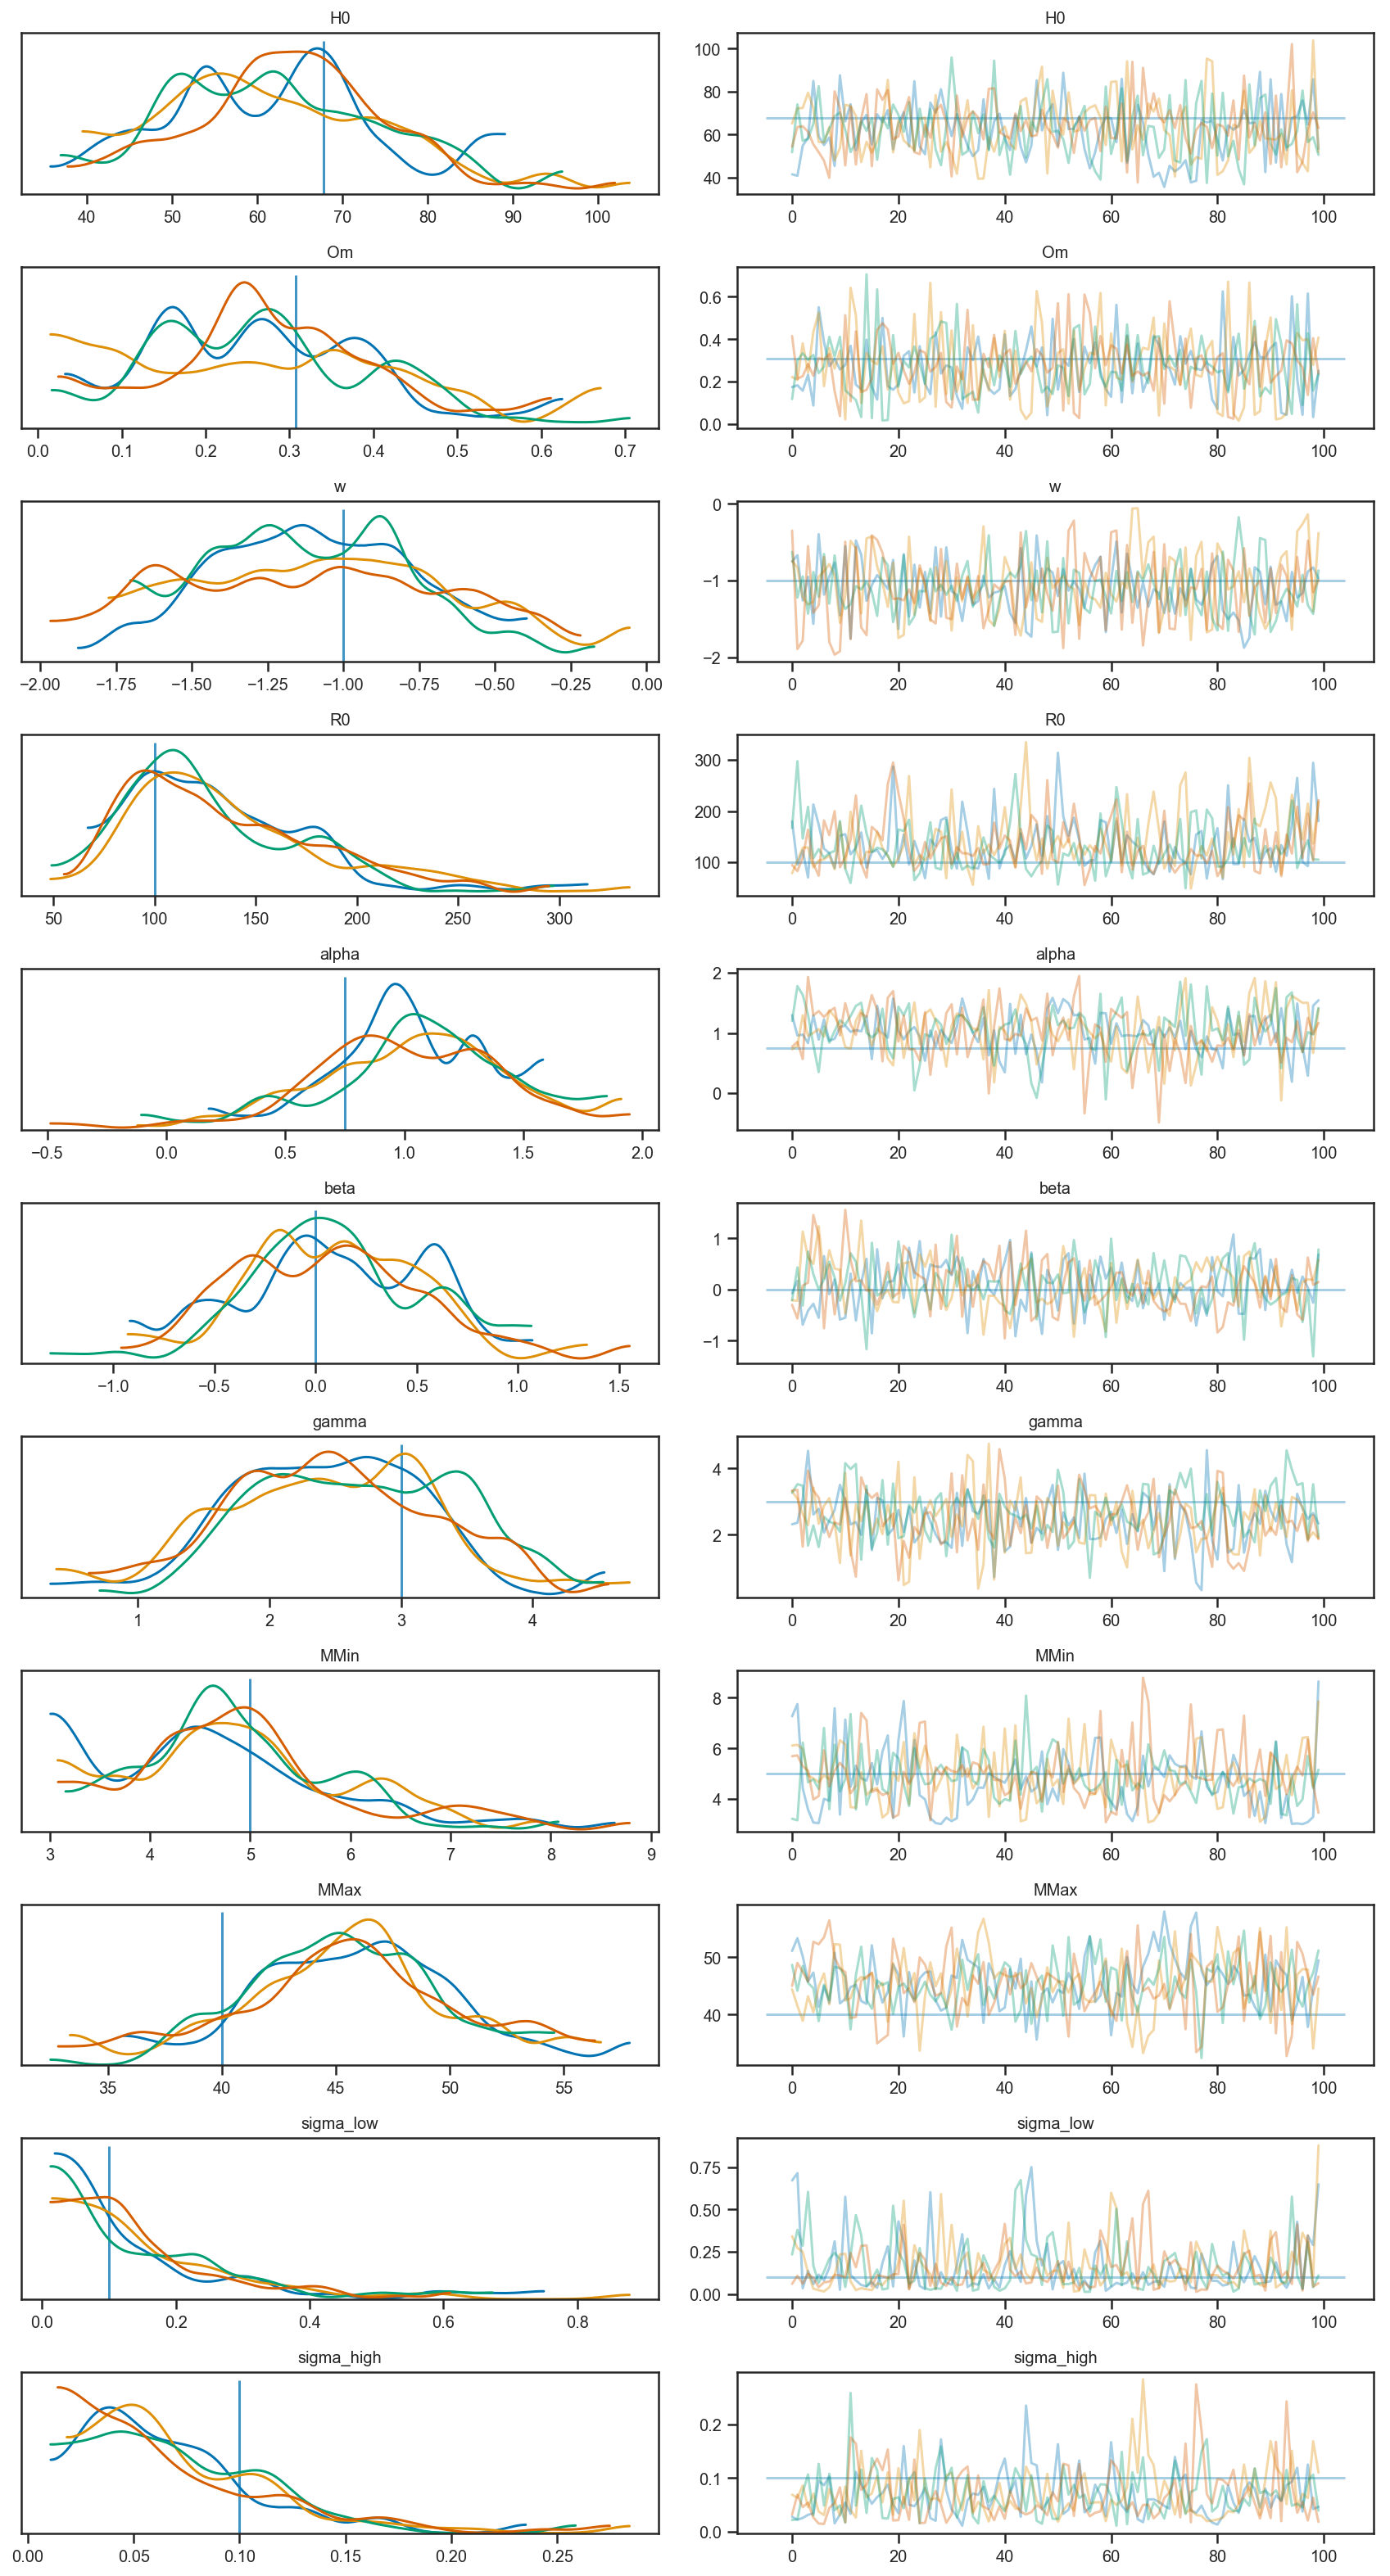

In [13]:
names = ['H0', 'Om', 'w', 'R0', 'alpha', 'beta', 'gamma', 'MMin', 'MMax', 'sigma_low', 'sigma_high']
lines = [(k, {}, true_params[k]) for k in names]

az.plot_trace(fit, var_names=names, lines=lines)